In [20]:
# imports
import pandas as pd, pymongo, pandas as pd, ipywidgets as widgets, scipy.stats as stats, math, matplotlib.pyplot as plt

# Third Hypotesis:

In the following notebook it will be analyzed the following hypotesis:
 - **Are people more loyal to a specific game genre** *(no matter which type of genre)***, or do they like changing it?**

## Local analysis

First we'll consider a small set of data, in order to locally perform the analysis using standard python and its libraries.<br>
If relevant results are obtained, the analysis will be replicated by using Big Data tools (HDFS, Spark, ...).

### Obtaining games genre/s

- **TODO:** Read the games data not directly from .csv but from a .json 

In [21]:
# load the games dataset and keep only appid and genres 
games_df = pd.read_csv("../../datasets/games/steam.csv")
games_df = games_df[['appid', 'genres']]

In [22]:
# split genres string into a list
games_df['genres'] = games_df.genres.str.split(';')

In [23]:
games_df

,appid,genres
0,10,[Action]
1,20,[Action]
2,30,[Action]
3,40,[Action]
4,50,[Action]
5,60,[Action]
6,70,[Action]
7,80,[Action]
8,130,[Action]
9,220,[Action]


#### Create a dataframe that contains for each game a 1 on the column of a specific genre if the game is of that genre

It is a sort of one hot encoding, but a game can at least have one genre

In [24]:
# get all unique genres
all_genres = games_df.genres.apply(pd.Series).stack().reset_index(drop=True).unique()
# a dict for each game, each dict has all of the genres, val=1 if genre applies to game
gen_dicts = games_df.genres.apply(lambda gens : { **{g:0 for g in all_genres}, **{ g:1 for g in gens } } )
# delete now useless column
del games_df['genres']
# merge with original
games_df = pd.concat( [games_df.reset_index(drop=True), gen_dicts.apply(pd.Series).reset_index(drop=True)] , axis=1)

In [25]:
games_df

,appid,Action,Free to Play,Strategy,Adventure,Indie,RPG,Animation & Modeling,Video Production,Casual,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,10,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,60,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,80,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,130,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,220,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Obtaining useful reviews data

In [26]:
# Connect to the mongo local and load as a dataframe the small_reviews collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
# only keep useful data
small_reviews_df = pd.DataFrame(list(mongo_db.small_reviews.find({}, {'_id': False})))
mongo.close() #Close the connection

In [27]:
# only keep useful data
small_reviews_df = small_reviews_df[['appid', 'steamid', 'voted_up']]

### Merge reviews and games genre/s datasets

In [28]:
entire_df = small_reviews_df.merge(games_df, on='appid')
entire_df

,appid,steamid,voted_up,Action,Free to Play,Strategy,Adventure,Indie,RPG,Animation & Modeling,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,204100,76561198289058616,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,204100,76561198372464367,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,204100,76561198058159765,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,204100,76561198090877508,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,204100,76561198142653504,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,204100,76561199104471182,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,204100,76561198987400304,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,204100,76561197975151824,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,204100,76561198291360667,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,204100,76561198041614319,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### (ASIDE) Is a specific genre more appreciated with respect to others? 
The metric useful for that analysis is the following: 
 - **genre_appreciation = (num_pos_reviews_genre / num_reviews_genre) * 100**


In [29]:
genre_appreciation = round(((entire_df[entire_df.voted_up].sum() / entire_df.sum())[3:].sort_values(ascending=False) * 100), 2).fillna(0)
genre_appreciation

Animation & Modeling     97.81
Design & Illustration    97.38
Utilities                96.07
Photo Editing            90.00
Indie                    89.27
Simulation               88.27
Casual                   88.12
RPG                      87.34
Web Publishing           87.21
Strategy                 86.63
Racing                   86.43
Early Access             86.31
Video Production         86.21
Sports                   86.06
Audio Production         85.71
Action                   85.71
Free to Play             85.31
Adventure                84.19
Nudity                   81.90
Gore                     81.04
Game Development         80.00
Violent                  79.56
Sexual Content           78.25
Massively Multiplayer    73.15
Education                71.70
Software Training        70.21
Accounting                0.00
Documentary               0.00
Tutorial                  0.00
dtype: float64

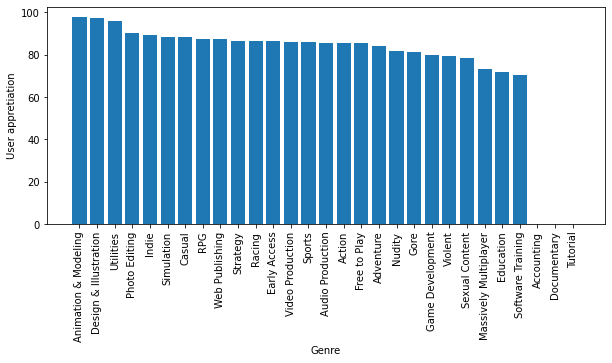

In [30]:
# Show the bar plot, in order to see if a/some genre/s is/are more appreciated by the users with respect to others
plt.figure(figsize=(10,4))
plt.bar(genre_appreciation.index, genre_appreciation)
plt.xlabel('Genre')
plt.ylabel('User appretiation')
plt.xticks(rotation=90);

### Analysis of the hypothesis

The first objective is to find for the users (that have written at least N positive reviews) which are their relative fidelity level to the more liked genre, which has been defined as:
 - **user_fidelity = (num_pos_reviews_most_reviewed_genre / num_pos_reviews) * 100**

<br> Once obtained that fidelity level for each user, we want to know if at least a percentage of users that have written at least N positive reviews are all loyal to the same genre (no matter which one). <br>
In order to have a measure on the statistical significance of that hypotesis a *Mean Test* has been performed.<br>
This test (fixed M) works as follows:
 - H0: mu = M%
 - H1: mu >= M%
 
Whereas the significance level is a percentage probability of accidentally making the wrong conclusion.<br>
For more details read the following link:
 - https://www.w3schools.com/statistics/statistics_hypothesis_testing_mean.php

In [31]:
# Select only the positive reviews
entire_df = entire_df[entire_df.voted_up]

In [32]:
# players that have positively reviewed at least N games (N is selectable)
written_reviews_each_user = entire_df.steamid.value_counts()
n_pos_reviews_slider = widgets.IntSlider(min=1, max=(written_reviews_each_user.max()), value=4)

In [33]:
steamid_written_n_pos_reviews = entire_df.steamid.value_counts()[entire_df.steamid.value_counts() >= n_pos_reviews_slider.value].index
len(steamid_written_n_pos_reviews)

386

In [34]:
# small_entire_df contains the details of the users (review + game reviewed genre/s info) that have written at least N positive reviews
small_entire_df = entire_df[entire_df.steamid.apply(lambda x : x in steamid_written_n_pos_reviews)]

# Select for each user which is the number of reviews of the more reviewed genre
num_pos_reviews_most_reviewed_genre = small_entire_df.groupby('steamid').sum().iloc[:, 2:].max(axis=1)

In [35]:
# User fidelity measures how much a user is loyal to the more played genre
num_pos_reviews = small_entire_df.groupby('steamid').sum().voted_up
user_fidelity = num_pos_reviews_most_reviewed_genre / num_pos_reviews * 100
user_fidelity

steamid
76561197960271994     75.000000
76561197960319772     83.333333
76561197960344344     80.000000
76561197960373660     62.500000
76561197960396581     75.000000
76561197960940977    100.000000
76561197961038549    100.000000
76561197961093505     75.000000
76561197961167439     75.000000
76561197962324014     50.000000
76561197962775424    100.000000
76561197963297973     50.000000
76561197964009814    100.000000
76561197964082949    100.000000
76561197965467305     80.000000
76561197966788390     60.000000
76561197966852598     75.000000
76561197967244540     75.000000
76561197967525009    100.000000
76561197967817775     75.000000
76561197968355020     75.000000
76561197968826351     75.000000
76561197969025704     75.000000
76561197969062133     75.000000
76561197969417125     83.333333
76561197969749884     50.000000
76561197969915893     80.000000
76561197970024915     50.000000
76561197970078168     80.000000
76561197970094946     50.000000
                        ...    


#### Statistical test

In [36]:
# Specify the sample mean (x_bar), the sample standard deviation (s), the mean claimed in the null-hypothesis (mu_null), and the sample size (n)
x_bar = user_fidelity.mean()
s = user_fidelity.std()
mu = 70
n = len(user_fidelity)

# Calculate the test statistic
statistics = (x_bar - mu)/(s / math.sqrt(n))

# # Output the p-value of the test statistic (right tailed test)
p_value =  1 - stats.t.cdf(statistics , n - 1)

print(f"Mean test coefficient: {statistics:.3f} \nP-value: {p_value:.3f}")
# Level of significance
alpha = 0.05
# conclusion
if p_value < alpha:
    # users tend to be loyal to the same genre, no matter which genre
    print('\nReject the null hypothesis')
else:
    # opposite of above
    print('\nDo not reject the null hypothesis')


Mean test coefficient: 8.260 
P-value: 0.000

Reject the null hypothesis


## Big Data analysis